In [103]:
# Get ELENA
!git clone https://github.com/michelelucente/ELENA.git
%cd ELENA

# Install Python deps for notebooks + examples
# (names follow ELENA’s README; CosmoTransitions is on PyPI)
%pip install -q numpy scipy matplotlib cosmoTransitions NatPy la-forge


Cloning into 'ELENA'...
remote: Enumerating objects: 420, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 420 (delta 12), reused 9 (delta 2), pack-reused 393 (from 1)
Receiving objects: 100% (420/420), 22.56 MiB | 36.55 MiB/s, done.
Resolving deltas: 100% (270/270), done.
/content/ELENA/ELENA/ELENA/ELENA


In [105]:
# Add ELENA/src to the Python path for imports (as suggested by the repo)
import sys, os
sys.path.append(os.path.abspath('src'))

In [121]:
# veff_elena.py – Abelian–Higgs effective potential with explicit T-dependence (3D DR form)
import numpy as np

# ---------- numerically safe helpers ----------
def _rtabs(x, floor=1e-30):
    """sqrt(|x|) with a tiny floor (keeps logs/ratios finite but preserves cancellations)."""
    return np.sqrt(np.maximum(np.abs(x), floor))

def _logsafe(x):
    return np.log(np.clip(np.abs(x), 1e-30, None))

# ---------- 4D input couplings ----------
g1_4   = 0.54
lam_4  = 1.65e-3
m0sq_4 = -(130.0**2)
Yphi   = 1.0

# ---------- thermal matching (placeholder; swap with DRalgo) ----------
cT   = 0.30*(g1_4**2) + 0.10*lam_4
c_mu = 1.0

def match_3d_params(T):
    T = float(T)
    g1sq_3 = (g1_4**2) * T           # [mass]^1
    lam_3  = lam_4 * T               # [mass]^1
    msq_3  = m0sq_4 + cT * T*T       # [mass]^2
    mu3US  = c_mu * max(g1_4*T, 1.0) # keep >0 at very low T
    return g1sq_3, lam_3, msq_3, mu3US

# ---------- stable small-ϕ handling for the three blocks ----------
def _MG_abs(phi, g1sq):
    # exact |ϕ| dependence prevents spurious constant pieces in logs
    return np.abs(phi) * np.sqrt(np.maximum(g1sq * (Yphi**2), 1e-30))

def _N_block1(phi, g1sq, lam, msq, mu3US):
    pi2  = np.pi**2
    phi2 = phi*phi
    M3   = _rtabs(msq + 3.0*lam*phi2)
    MG   = _MG_abs(phi, g1sq)

    term1 =  (g1sq**2)*(Yphi**4)*phi2**2 / (8.0*pi2)
    term2 = -(g1sq*(Yphi**2)*phi2*(-msq + 2.0*g1sq*(Yphi**2)*phi2 - 3.0*lam*phi2)) / (16.0*pi2)
    term3 =  (g1sq*(Yphi**2)*phi2*MG*M3) / (8.0*pi2)
    term4 = - ((msq + 3.0*lam*phi2)**2) * (0.5 + _logsafe(mu3US / M3)) / (16.0*pi2)
    tmp   = (-msq + g1sq*(Yphi**2)*phi2 - 3.0*lam*phi2)
    term5 =  (tmp*tmp) * (0.5 + _logsafe(mu3US / (MG + M3))) / (8.0*pi2)
    term6n = ( 7.0*(g1sq**2)*(Yphi**4)*phi2**2 + tmp*tmp - 2.0*g1sq*(Yphi**2)*phi2*(msq + 3.0*lam*phi2) )
    term6  = - term6n * (0.5 + _logsafe(mu3US / (2.0*MG + M3))) / (16.0*pi2)
    return term1 + term2 + term3 + term4 + term5 + term6

def _N_block2(phi, g1sq, lam, msq, mu3US):
    pi   = np.pi
    pi2  = pi**2
    phi2 = phi*phi
    M1   = _rtabs(msq + lam*phi2)
    M3   = _rtabs(msq + 3.0*lam*phi2)
    MG   = _MG_abs(phi, g1sq)

    t1 = - (MG * (g1sq*(Yphi**2)*phi2 - 2.0*lam*phi2) * M1) / (16.0*pi2)
    t2 =  (M3 / (4.0*pi)) * ((g1sq*(Yphi**2)*phi2*M1)/(4.0*pi)
                             - (MG*(g1sq*(Yphi**2)*phi2 + 2.0*lam*phi2))/(4.0*pi))
    t3 =  (lam**2 * phi2**2) * (0.5 + _logsafe(mu3US / (M1 + M3))) / (4.0*pi2)
    num = ( (g1sq**2)*(Yphi**4)*phi2**2 + 4.0*lam**2*phi2**2
          - 2.0*g1sq*(Yphi**2)*phi2*(2.0*msq + 4.0*lam*phi2) )
    t4 = - num * (0.5 + _logsafe(mu3US / (MG + M1 + M3))) / (16.0*pi2)
    return t1 + t2 + t3 + t4

def _N_block3(phi, g1sq, lam, msq, mu3US):
    pi   = np.pi
    pi2  = pi**2
    phi2 = phi*phi
    M1   = _rtabs(msq + lam*phi2)
    M3   = _rtabs(msq + 3.0*lam*phi2)
    MG   = _MG_abs(phi, g1sq)

    t1 = - (MG * (g1sq*(Yphi**2)*phi2 + 2.0*lam*phi2) * M3) / (16.0*pi2)
    t2 =  (M1 / (4.0*pi)) * ( - (MG * (g1sq*(Yphi**2)*phi2 - 2.0*lam*phi2)) /(4.0*pi)
                               + (g1sq*(Yphi**2)*phi2*M3) / (4.0*pi) )
    t3 =  (lam**2 * phi2**2) * (0.5 + _logsafe(mu3US / (M1 + M3))) / (4.0*pi2)
    num = ( (g1sq**2)*(Yphi**4)*phi2**2 + 4.0*lam**2*phi2**2
          - 2.0*g1sq*(Yphi**2)*phi2*(2.0*msq + 4.0*lam*phi2) )
    t4 = - num * (0.5 + _logsafe(mu3US / (MG + M1 + M3))) / (16.0*pi2)
    return t1 + t2 + t3 + t4

def _block_stable(phi, g1sq, lam, msq, mu3US, Nfunc, phi_cut=1e-2, h_abs=1e-4):
    """
    Stable evaluation of N(phi)/(4 phi^2):
      if |phi|>=phi_cut -> direct ratio
      else -> even-limit via symmetric second-difference using a fixed |h| (not ∝phi)
    """
    phi = float(phi)
    if abs(phi) >= phi_cut:
        return Nfunc(phi, g1sq, lam, msq, mu3US) / (4.0 * phi*phi)
    h = h_abs
    Nhp = Nfunc(+h, g1sq, lam, msq, mu3US)
    Nhm = Nfunc(-h, g1sq, lam, msq, mu3US)
    a   = (Nhp + Nhm) / (2.0 * h*h)  # coefficient of phi^2 in N(phi)
    return 0.25 * a

# ---------- Effective potential ----------
def V(phi, T):
    phi = np.asarray(phi, dtype=float)
    T   = np.asarray(T,   dtype=float)

    g1sq, lam, msq, mu3US = match_3d_params(T)
    g1sq  = np.asarray(g1sq,  dtype=float)
    lam   = np.asarray(lam,   dtype=float)
    msq   = np.asarray(msq,   dtype=float)
    mu3US = np.asarray(mu3US, dtype=float)

    pi  = np.pi
    pi2 = pi**2

    phi2 = phi*phi
    M1   = _rtabs(msq + lam*phi2)
    M3   = _rtabs(msq + 3.0*lam*phi2)
    MG   = _MG_abs(phi, g1sq)

    term_tree  = 0.5 * msq * phi2 + 0.25 * lam * phi2**2
    term_cg    = - (MG**3) / (6.0 * pi)
    term_c1    =  (g1sq * (Yphi**2) * MG * M1) / (16.0 * pi2)
    term_l1    =  (3.0 * lam * (msq + lam * phi2)) / (64.0 * pi2)
    term_sc1   = - (M1**3) / (12.0 * pi)
    term_c2    =  (g1sq * (Yphi**2) * MG * M3) / (16.0 * pi2)
    term_mix   =  (lam * M1 * M3) / (32.0 * pi2)
    term_l2    =  (3.0 * lam * (msq + 3.0 * lam * phi2)) / (64.0 * pi2)
    term_sc2   = - (M3**3) / (12.0 * pi)
    term_log_scalar = - (3.0 * lam**2 * phi2) / (16.0 * pi2) * (0.5 + _logsafe(mu3US / (3.0 * M3)))
    term_last       = - (lam**2 * phi2) / (16.0 * pi2) * (0.5 + _logsafe(mu3US / (2.0 * M1 + M3)))

    # stabilized blocks (vectorized over phi)
    b1 = np.vectorize(_block_stable)(phi, g1sq, lam, msq, mu3US, _N_block1)
    b2 = np.vectorize(_block_stable)(phi, g1sq, lam, msq, mu3US, _N_block2)
    b3 = np.vectorize(_block_stable)(phi, g1sq, lam, msq, mu3US, _N_block3)

    return term_tree + term_cg + term_c1 + term_l1 + term_sc1 + term_c2 + term_mix + term_l2 + term_sc2 + term_log_scalar + b1 + b2 + b3 + term_last

def dV(phi, T):
    phi = np.asarray(phi, dtype=float)
    # step independent of phi near zero → stable with |ϕ| cusps
    h = 1e-3 * np.maximum(1.0, np.abs(phi)) + 1e-5
    return (V(phi + h, T) - V(phi - h, T)) / (2.0 * h)

if __name__ == "__main__":
    Ts = [0.0, 50.0, 100.0, 150.0, 200.0]
    for T in Ts:
        for ph in [0.0, 1e-6, 1e-3, 0.1, 1.0, 10.0, 50.0]:
            print(f"T={T:6.1f}, phi={ph:9.6f}, V={V(ph,T): .4e}, dV={dV(ph,T): .4e}")

T=   0.0, phi= 0.000000, V=-1.1655e+05, dV= 0.0000e+00
T=   0.0, phi= 0.000001, V=-1.1655e+05, dV=-1.6900e-02
T=   0.0, phi= 0.001000, V=-1.1655e+05, dV=-1.6900e+01
T=   0.0, phi= 0.100000, V=-1.1664e+05, dV=-1.6900e+03
T=   0.0, phi= 1.000000, V=-1.2500e+05, dV=-1.6900e+04
T=   0.0, phi=10.000000, V=-9.6155e+05, dV=-1.6900e+05
T=   0.0, phi=50.000000, V=-2.1242e+07, dV=-8.4500e+05
T=  50.0, phi= 0.000000, V=-1.0889e+05, dV= 0.0000e+00
T=  50.0, phi= 0.000001, V=-1.0889e+05, dV= 7.3487e-02
T=  50.0, phi= 0.001000, V=-1.0889e+05, dV= 7.3487e+01
T=  50.0, phi= 0.100000, V=-1.0895e+05, dV=-1.4857e+03
T=  50.0, phi= 1.000000, V=-1.1705e+05, dV=-1.6504e+04
T=  50.0, phi=10.000000, V=-9.4349e+05, dV=-1.6734e+05
T=  50.0, phi=50.000000, V=-2.1173e+07, dV=-8.4486e+05
T= 100.0, phi= 0.000000, V=-1.0144e+05, dV= 0.0000e+00
T= 100.0, phi= 0.000001, V=-1.0144e+05, dV= 2.3393e-01
T= 100.0, phi= 0.001000, V=-1.0144e+05, dV= 2.3393e+02
T= 100.0, phi= 0.100000, V=-1.0147e+05, dV=-1.0987e+03
T= 100.0, 

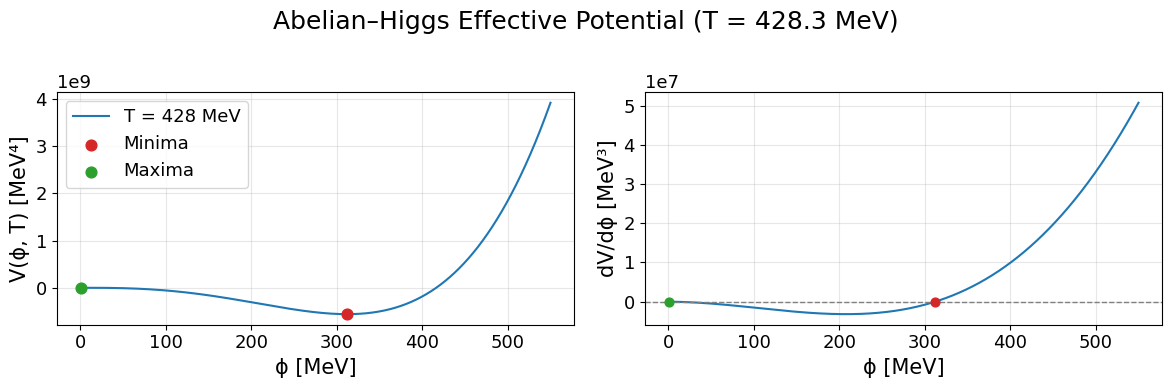

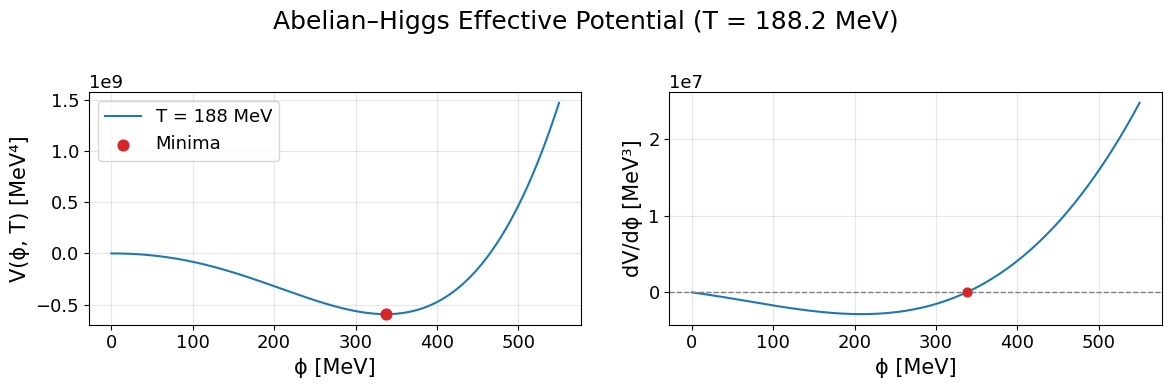

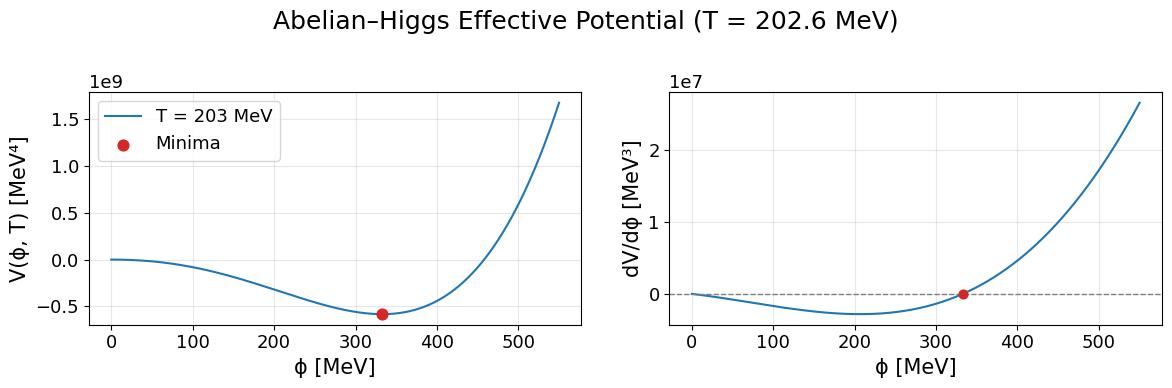

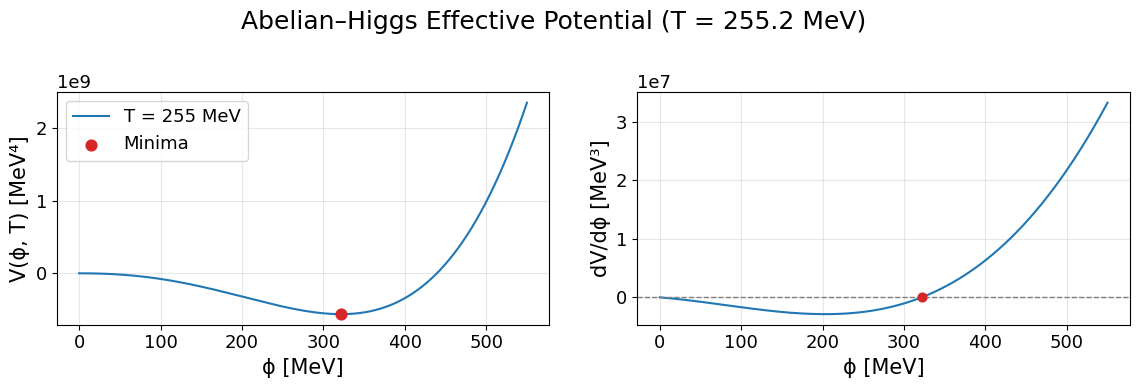

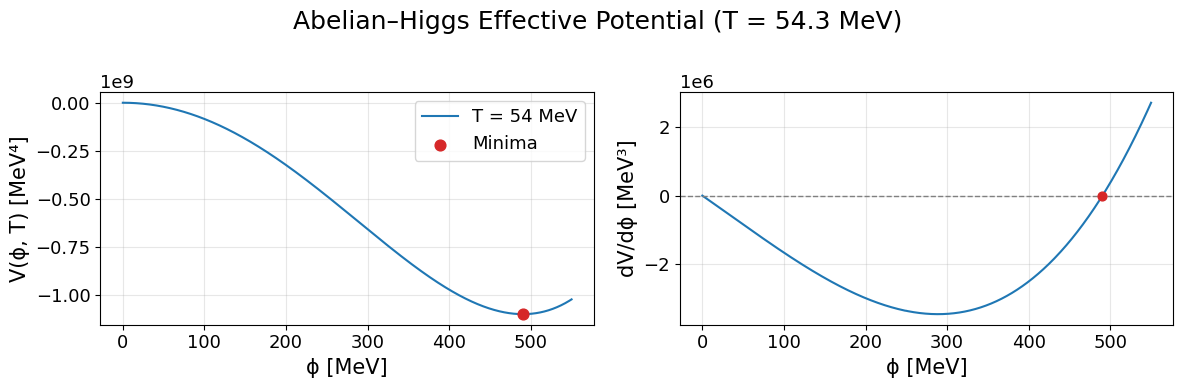

In [107]:
# plot_ah_potential.py – visualize Abelian–Higgs effective potential with explicit T-dependence
import numpy as np
import matplotlib.pyplot as plt
import warnings



# -------------------------------
# Global plot settings (no LaTeX)
# -------------------------------
warnings.filterwarnings("ignore", category=RuntimeWarning)
plt.rcParams.update({
    'font.size': 16,
    'axes.titlesize': 18,
    'axes.labelsize': 15,
    'xtick.labelsize': 13,
    'ytick.labelsize': 13,
    'legend.fontsize': 13,
    'figure.titlesize': 18,
    'text.usetex': False
})

# -------------------------------
# Controls
# -------------------------------
vev   = 500.0                  # plot window scale [MeV]
units = "MeV"
temps = np.random.uniform(0, vev, size=5)  # scan a few T
phi   = np.linspace(0, 1.1*vev, 2601)
phi = phi.reshape(-1,1)
# -------------------------------
# Helpers to find extrema
# -------------------------------
def zero_crossings(x, y):
    """Return indices i where y crosses 0 between x[i] and x[i+1]."""
    s = np.sign(y)
    cross = np.where(s[:-1] * s[1:] < 0)[0]
    return cross

def interp_zero(x0, x1, y0, y1):
    """Linear interpolation for zero of y between (x0,y0) and (x1,y1)."""
    t = -y0 / (y1 - y0)
    return x0 + t*(x1 - x0)

def find_extrema(phi_grid, T, dV_vals=None):
    """
    Find stationary points solving dV=0 along the grid, classify them using a
    second-derivative sign test via finite differences.
    Returns list of (phi_star, kind) with kind in {'min','max','flat'}.
    """
    if dV_vals is None:
        dV_vals = dV(phi_grid, T)

    idxs = zero_crossings(phi_grid, dV_vals)
    extrema = []
    for i in idxs:
        # refine root by linear interpolation
        x0, x1 = phi_grid[i], phi_grid[i+1]
        y0, y1 = dV_vals[i], dV_vals[i+1]
        xc = interp_zero(x0, x1, y0, y1)

        # classify via finite-difference second derivative
        h  = max(1e-2, 1e-3*max(abs(xc), 1.0))
        fpp = (V(xc + h, T) - 2.0*V(xc, T) + V(xc - h, T)) / (h*h)

        if fpp > 0:
            kind = 'min'
        elif fpp < 0:
            kind = 'max'
        else:
            kind = 'flat'
        extrema.append((xc, kind))
    return extrema

# -------------------------------
# Plot
# -------------------------------
for T in temps:
    Vvals  = V(phi, T)
    dVvals = dV(phi, T)

    # find extrema
    extrema = find_extrema(phi, T, dVvals)
    mins = [x for x,k in extrema if k=='min']
    maxs = [x for x,k in extrema if k=='max']

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle(f"Abelian–Higgs Effective Potential (T = {T:.1f} {units})", fontsize=18)

    # --- Left: V(φ) ---
    axes[0].plot(phi, Vvals, label=f"T = {T:.0f} {units}")
    # mark minima & maxima
    if mins:
        axes[0].scatter(mins, [V(m, T) for m in mins], s=60, c='tab:red', label='Minima', zorder=5)
    if maxs:
        axes[0].scatter(maxs, [V(m, T) for m in maxs], s=60, c='tab:green', label='Maxima', zorder=5)
    axes[0].set_xlabel(f"ϕ [{units}]")
    axes[0].set_ylabel(f"V(ϕ, T) [{units}⁴]")
    axes[0].grid(alpha=0.3)
    axes[0].legend(loc="best")

    # annotate two-well structure on φ≥0 side if present
    mins_pos = sorted([m for m in mins if m >= 0.0])
    if len(mins_pos) >= 1:
        m0 = mins_pos[0]
        V0 = V(m0, T)
        # find next minimum to the right if any
        if len(mins_pos) >= 2:
            m1 = mins_pos[1]
            V1 = V(m1, T)
            axes[0].annotate("Barrier", xy=(0.5*(m0+m1), V(0.5*(m0+m1), T)),
                             xytext=(0.5*(m0+m1), V(0.5*(m0+m1), T) + 0.1*abs(V1 - V0) + 1e-3),
                             arrowprops=dict(arrowstyle="->", lw=1))

    # --- Right: dV/dφ ---
    axes[1].plot(phi, dVvals)
    axes[1].axhline(0, color="gray", linestyle="--", linewidth=1)
    if mins:
        axes[1].scatter(mins, [0.0]*len(mins), s=40, c='tab:red', zorder=5)
    if maxs:
        axes[1].scatter(maxs, [0.0]*len(maxs), s=40, c='tab:green', zorder=5)
    axes[1].set_xlabel(f"ϕ [{units}]")
    axes[1].set_ylabel(f"dV/dϕ [{units}³]")
    axes[1].grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

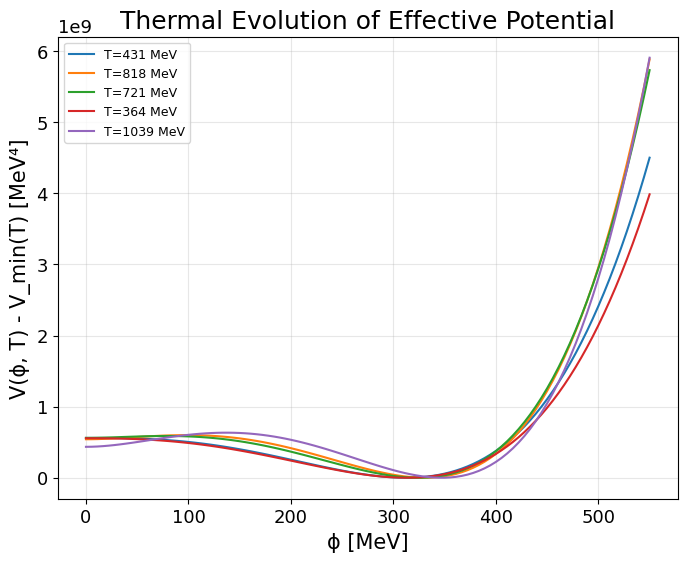

In [108]:
import numpy as np
import matplotlib.pyplot as plt


Tscan = np.random.uniform(0, 2.5*vev, size=20)   # MeV, generate an array of temperatures
phi   = np.linspace(0, 1.1*vev, 100)
phi = phi.reshape(-1,1)

plt.figure(figsize=(8,6))
for T in Tscan[::4]:  # plot a few representative temperatures
    Vvals = V(phi, T)
    Vvals -= Vvals.min()           # normalize so min=0 for visibility
    plt.plot(phi, Vvals, label=f"T={T:.0f} MeV")

plt.xlabel("ϕ [MeV]")
plt.ylabel("V(ϕ, T) - V_min(T) [MeV⁴]")
plt.title("Thermal Evolution of Effective Potential")
plt.legend(fontsize=9)
plt.grid(alpha=0.3)
plt.show()

In [109]:
import numpy as np

# symmetric energy is always at phi=0
def Esym(T):
    return float(V(0.0, T))

# broken-phase minimum: search only at |phi| >= phi_cut
def Ebroken(T, phimax=600.0, npts=2001, phi_cut=5.0):
    # scan φ >= φ_cut (use symmetry φ→−φ)
    phi = np.linspace(phi_cut, phimax, npts)
    Vvals = V(phi, T)
    i = np.argmin(Vvals)
    return float(phi[i]), float(Vvals[i])

def deltaV(T, phimax=600.0, phi_cut=5.0):
    phib, Vb = Ebroken(T, phimax=phimax, phi_cut=phi_cut)
    V0 = Esym(T)
    return V0 - Vb, phib
T0 = 1395.0  # <- whatever root your solver gave you

for dT in [-20, -10, -5, -1, 0, 1, 5, 10, 20]:
    T = T0 + dT
    delta_V_value, phib = deltaV(T) # Renamed dV to delta_V_value to avoid shadowing the function
    print(f"T = {T:7.2f} MeV  ΔV(T) = {delta_V_value: .4e}  φ_b(T) = {phib: .2f}")

T = 1375.00 MeV  ΔV(T) =  5.7906e+07  φ_b(T) =  373.31
T = 1385.00 MeV  ΔV(T) =  4.1906e+07  φ_b(T) =  373.90
T = 1390.00 MeV  ΔV(T) =  3.3791e+07  φ_b(T) =  374.50
T = 1394.00 MeV  ΔV(T) =  2.7245e+07  φ_b(T) =  374.79
T = 1395.00 MeV  ΔV(T) =  2.5602e+07  φ_b(T) =  374.79
T = 1396.00 MeV  ΔV(T) =  2.3954e+07  φ_b(T) =  374.79
T = 1400.00 MeV  ΔV(T) =  1.7334e+07  φ_b(T) =  375.09
T = 1405.00 MeV  ΔV(T) =  8.9885e+06  φ_b(T) =  375.39
T = 1415.00 MeV  ΔV(T) = -1.9104e+06  φ_b(T) =  5.00


In [134]:
import numpy as np, gc
units = "MeV"

# === 1) Scalar wrappers using ONLY your V ===
def V_s(phi, T):
    return float(V(float(phi), float(T)))

def dV_s(phi, T):
    """Numerical derivative dV/dϕ via central finite difference (scalar)."""
    phi = float(phi)
    T   = float(T)
    h   = 1e-3 * max(1.0, abs(phi)) + 1e-6
    return (V_s(phi + h, T) - V_s(phi - h, T)) / (2.0*h)


# === 2) Streaming extrema finder (no big arrays) ===
def stream_extrema(T, phimin=0.0, phimax=1000.0, dphi=5.0):
    mins, maxs = [], []

    phi_prev = phimin
    dprev    = dV_s(phi_prev, T)
    phi      = phimin + dphi

    while phi <= phimax:
        dcur = dV_s(phi, T)

        # detect zero crossing of derivative
        if dprev * dcur < 0.0:
            a, b = phi_prev, phi
            # refine root of dV = 0
            for _ in range(24):
                m  = 0.5*(a + b)
                dm = dV_s(m, T)
                if dprev * dm <= 0.0:
                    b = m
                else:
                    a, dprev = m, dm

            phistar = 0.5*(a + b)

            # classify extremum with second derivative
            h   = max(1e-2, 1e-3*max(1.0, abs(phistar)))
            fpp = (V_s(phistar+h, T) - 2*V_s(phistar, T) + V_s(phistar-h, T)) / (h*h)

            if fpp > 0:
                mins.append((phistar, V_s(phistar, T)))
            else:
                maxs.append((phistar, V_s(phistar, T)))

        phi_prev, dprev = phi, dcur
        phi += dphi

    return mins, maxs


def zero_is_min(T, eps=1e-2):
    """Check if φ=0 behaves like a local minimum (even potential)."""
    return V_s(eps, T) > V_s(0.0, T)



def broken_exists(T, phimax=1000.0, dphi=5.0):
    """Is there a nonzero minimum at this T?"""
    mins, _ = stream_extrema(T, 0.0, phimax, dphi)
    return any(phi_star > 1e-6 for phi_star, _ in mins)


def barrier_exists(T, phimax=600.0, dphi=5.0):
    """
    Is there a barrier at this T?
    → at least two minima (including φ=0 if it's a minimum),
      with a maximum in between.
    """
    mins, maxs = stream_extrema(T, 0.0, phimax, dphi)

    if zero_is_min(T):
        mins = [(0.0, V_s(0.0, T))] + mins

    mins = sorted(mins, key=lambda x: x[0])
    if len(mins) < 2:
        return False

    m0, m1 = mins[0][0], mins[1][0]
    return any(m0 < M[0] < m1 for M in maxs)


# === 3) Find T_max (highest T with a broken minimum) ===
phi_scale  = 500.0           # adjust if your vev is different
PHIMAX     = 2.5 * phi_scale
DPHI       = 2.0

T_LO, T_HI = 0.0, 3.0 * phi_scale   # e.g. up to 1500 MeV if phi_scale=500
DT         = 5.0

T_max = None
last_has = False

T = T_LO
while T <= T_HI:
    ok = broken_exists(T, PHIMAX, DPHI)
    if ok:
        T_max = T
        last_has = True
    elif last_has:
        # lost broken minimum: just passed T_max
        break
    T += DT

# refine T_max by bisection
if T_max is not None:
    a, b = T_max, min(T_max + 20.0, T_HI)
    for _ in range(24):
        m = 0.5*(a+b)
        if broken_exists(m, PHIMAX, DPHI):
            a = m
        else:
            b = m
    T_max = a

gc.collect()


# === 4) Find T_min (first T with a barrier, below T_max) ===
T_min = None
if T_max is not None:
    T = max(T_max - 200.0, T_LO)
    while T >= T_LO:
        if barrier_exists(T, PHIMAX, DPHI):
            T_min = T
            break
        T -= DT

    if T_min is not None:
        a, b = T_min, min(T_min + 20.0, T_max)
        for _ in range(24):
            m = 0.5*(a+b)
            if barrier_exists(m, PHIMAX, DPHI):
                a = m
            else:
                b = m
        T_min = a

gc.collect()


# === 5) Print results ===
def fmt(x):
    return f"{x:.6e} {units}" if isinstance(x,(int,float,np.floating)) else "None"

print("Memory-safe scan complete:")
print(f"T_max = {fmt(T_max)}")
print(f"T_min (barrier onset) = {fmt(T_min)}")


Memory-safe scan complete:
T_max = 1.500000e+03 MeV
T_min (barrier onset) = 1.320000e+03 MeV


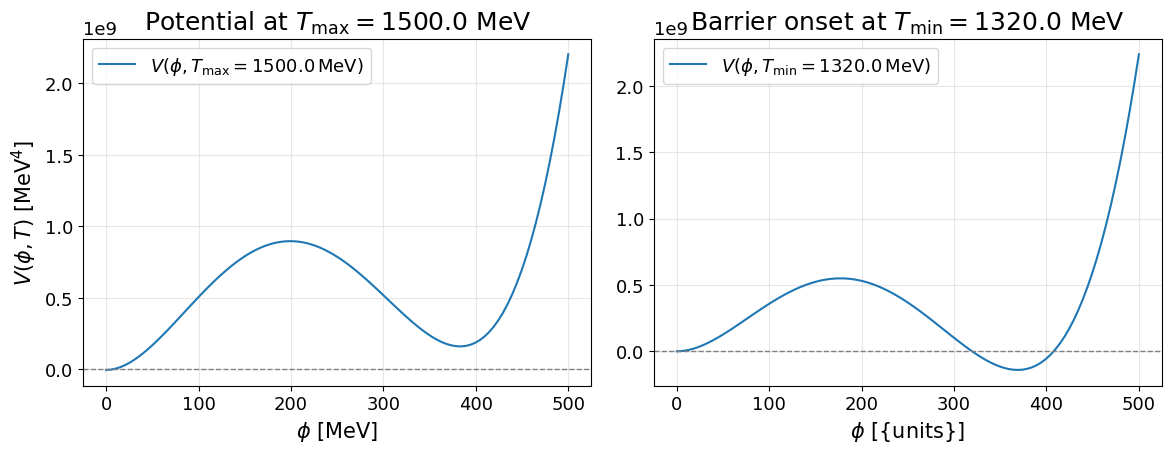

In [135]:
import numpy as np
import matplotlib.pyplot as plt

# --- prepare φ grid ---
phi = np.linspace(0, vev, 100)   # adjust as needed

# --- compute V(phi,T) safely ---
v_Tmax = V(phi, T_max) if T_max is not None else None
v_Tmin = V(phi, T_min) if T_min is not None else None

# --- decide number of panels ---
ncols = 2 if T_min is not None else 1
fig, axes = plt.subplots(1, ncols, figsize=(6*ncols, 5))

if ncols == 1:
    axes = [axes]   # make indexable

# ============================================================
#  LEFT PANEL: T_max (degeneracy / highest broken-temperature)
# ============================================================
if T_max is not None:
    ax = axes[0]
    ax.plot(phi, v_Tmax, label=rf"$V(\phi, T_\mathrm{{max}}={T_max:.1f}\,\mathrm{{MeV}})$")
    ax.set_title(rf"Potential at $T_\mathrm{{max}} = {T_max:.1f}$ {units}")
    ax.set_xlabel(r"$\phi$ [MeV]")
    ax.set_ylabel(r"$V(\phi, T)$ [MeV$^4$]")
    ax.axhline(0, color="gray", linestyle="--", linewidth=1)
    ax.grid(alpha=0.3)
    ax.legend()

# ============================================================
# RIGHT PANEL (only if T_min exists)
# ============================================================
if T_min is not None:
    ax = axes[1]
    ax.plot(phi, v_Tmin, label=rf"$V(\phi, T_\mathrm{{min}}={T_min:.1f}\,\mathrm{{MeV}})$")
    ax.set_title(rf"Barrier onset at $T_\mathrm{{min}} = {T_min:.1f}$ {units}")
    ax.set_xlabel(r"$\phi$ [{units}]")
    ax.axhline(0, color="gray", linestyle="--", linewidth=1)
    ax.grid(alpha=0.3)
    ax.legend()

plt.tight_layout()
plt.show()
